Here we will test parameter recovery and model comparison for Rescorla-Wagner(RW), Hierarchical Gaussian Filters (HGF), and Switching Gaussian Filters (SGF) models of the social influence task.

In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples')])

Lets start by generating some behavioral data from the social influence task. Here green advice/choice is encoded as 0 and the blue advice/choice is encoded as 1.

In [2]:
import torch
from torch import ones, zeros, tensor
torch.manual_seed(1234)

nsub = 50 #number of subjects
trials = 120 #number of samples

from befit.tasks import SocialInfluence
from befit.simulate import Simulator
from befit.inference import Horseshoe
from befit.agents import RLSocInf, HGFSocInf, SGFSocInf

# load stimuli (trial offers, advices, and reliability of advices)
outcomes = torch.from_numpy(np.load('advice_outcome.npy')).float()
outcomes = outcomes.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)
reliability = torch.from_numpy(2.*np.load('advice_reliability.npy')-1.).float()
reliability = reliability.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)

offers = torch.from_numpy(np.load('offers.npy')).reshape(trials, -1, 1).repeat(1, 1, nsub)\
            .reshape(trials, -1).unsqueeze(0)

mask = ones(1, trials, 2*nsub)

stimuli = {'outcomes': outcomes, 
           'offers': offers, 
           'reliability': reliability,
           'mask': mask}

socinfl = SocialInfluence(stimuli, nsub=nsub)

# RL agent
rl_agent = RLSocInf(runs=2*nsub, trials=trials)

trans_pars1 = torch.arange(-.5,.5,1/(2*nsub)).reshape(-1, 1) + tensor([[0., -2., 4., 0.]]) 
rl_agent.set_parameters(trans_pars1)

sim1 = Simulator(socinfl, rl_agent, runs=2*nsub, trials=trials)
sim1.simulate_experiment()

# HGF agent
hgf_agent = HGFSocInf(runs=2*nsub, trials=trials)

trans_pars2 = torch.arange(-.5, .5, 1/(2*nsub)).reshape(-1, 1) + tensor([[0., 2., 0., 4., 0.]]) 
hgf_agent.set_parameters(trans_pars2)

sim2 = Simulator(socinfl, hgf_agent, runs=2*nsub, trials=trials)
sim2.simulate_experiment()

# SGF agent
sgf_agent = SGFSocInf(runs=2*nsub, trials=trials)

trans_pars3 = torch.arange(-.5, .5, 1/(2*nsub)).reshape(-1, 1) + tensor([[0., -2., -1., 4., 0.]])
sgf_agent.set_parameters(trans_pars3)

sim3 = Simulator(socinfl, sgf_agent, runs=2*nsub, trials=trials)
sim3.simulate_experiment();

def posterior_accuracy(labels, df, vals):
    for i, lbl in enumerate(labels):
        std = df.loc[df['parameter'] == lbl].groupby(by='subject').std()
        mean = df.loc[df['parameter'] == lbl].groupby(by='subject').mean()
        print(lbl, np.sum(((mean+2*std).values[:, 0] > vals[i])*((mean-2*std).values[:, 0] < vals[i]))/(2*nsub))

plot performance of different agents in different blocks

RL agent:  [0.56666666 0.62083334]
HGF agent:  [0.5833333 0.6166667]
SGF agent:  [0.6   0.625]


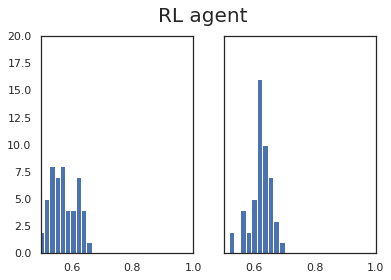

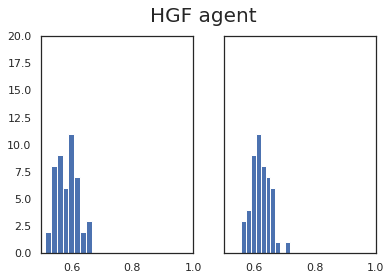

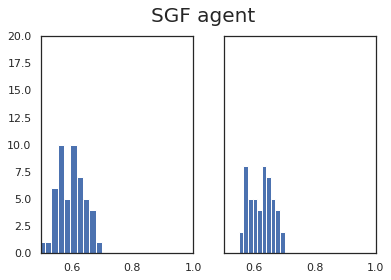

In [4]:
def compute_mean_performance(outcomes, responses):
    cc1 = (outcomes * responses > 0.).float()  # accept reliable offer
    cc2 = (outcomes * (1 - responses) < 0.).float() # reject unreliable offer
    
    return torch.einsum('ijk->k', cc1 + cc2)/trials

perf1 = compute_mean_performance(sim1.stimuli['outcomes'], sim1.responses).numpy().reshape(2, -1) 

print('RL agent: ', np.median(perf1, axis = -1))

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].hist(perf1[0]);
ax[1].hist(perf1[1]);
fig.suptitle('RL agent', fontsize = 20);
ax[0].set_ylim([0, 20]);
ax[0].set_xlim([.5, 1.]);

perf2 = compute_mean_performance(sim2.stimuli['outcomes'], sim2.responses).numpy().reshape(2, -1)
print('HGF agent: ', np.median(perf2, axis = -1))

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].hist(perf2[0]);
ax[1].hist(perf2[1]);
fig.suptitle('HGF agent', fontsize = 20);
ax[0].set_ylim([0, 20]);
ax[0].set_xlim([.5, 1.]);

perf3 = compute_mean_performance(sim3.stimuli['outcomes'], sim3.responses).numpy().reshape(2, -1)
print('SGF agent: ', np.median(perf3, axis = -1))

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
ax[0].hist(perf3[0]);
ax[1].hist(perf3[1]);
fig.suptitle('SGF agent', fontsize = 20);
ax[0].set_ylim([0, 20]);
ax[0].set_xlim([.5, 1.]);

Fit simulated behavior

In [11]:
stimuli = np.array(sim1.stimulus).reshape(1, -1)
mask = mask.byte()
rl_infer = Horseshoe(rl_agent, stimuli, sim1.responses, mask=mask)
rl_infer.infer_posterior(iter_steps=1000)

labels = [r'$V_0$', r'$\alpha$', r'$\zeta$', r'$\beta$']
tp_df, mu_df, sigma_df = rl_infer.sample_posterior(labels, n_samples=1000)

Mean ELBO 6816.61: 100%|██████████| 1000/1000 [11:04<00:00,  1.49it/s]


Compute fit quality and plot posterior estimates from a hierarchical parameteric model

In [12]:
labels = [r'$V_0$', r'$\alpha$', r'$\zeta$', r'$\beta$']
trans_pars_rl = tp_df.melt(id_vars='subject', var_name='parameter')

vals = [trans_pars1[:,0].numpy(), trans_pars1[:, 1].numpy(), trans_pars1[:, 2].numpy(), trans_pars1[:, 3].numpy()]
posterior_accuracy(labels, trans_pars_rl, vals)

$V_0$ 1.0
$\alpha$ 0.99
$\zeta$ 1.0
$\beta$ 0.99


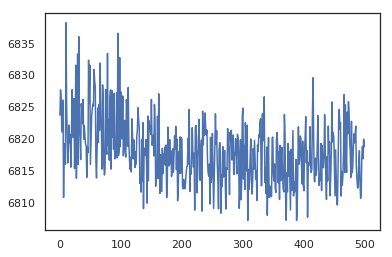

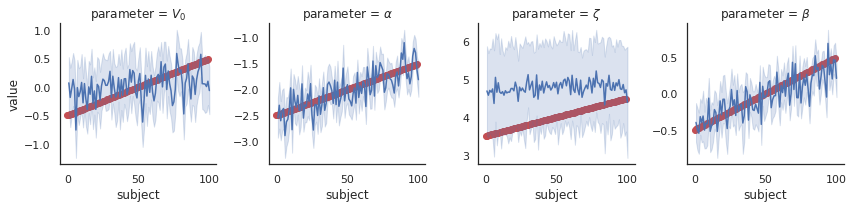

In [13]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(rl_infer.loss[-500:])

g = sns.FacetGrid(trans_pars_rl, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

labels = [r'$V_0$', r'$\alpha$', r'$\zeta$', r'$\beta$']
for i in range(len(labels)):
    g.axes[0,i].plot(np.arange(2*nsub), trans_pars1[:,i].numpy(),'ro', zorder = 0);

/mnt/data/miniconda/envs/pyro-ppl/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


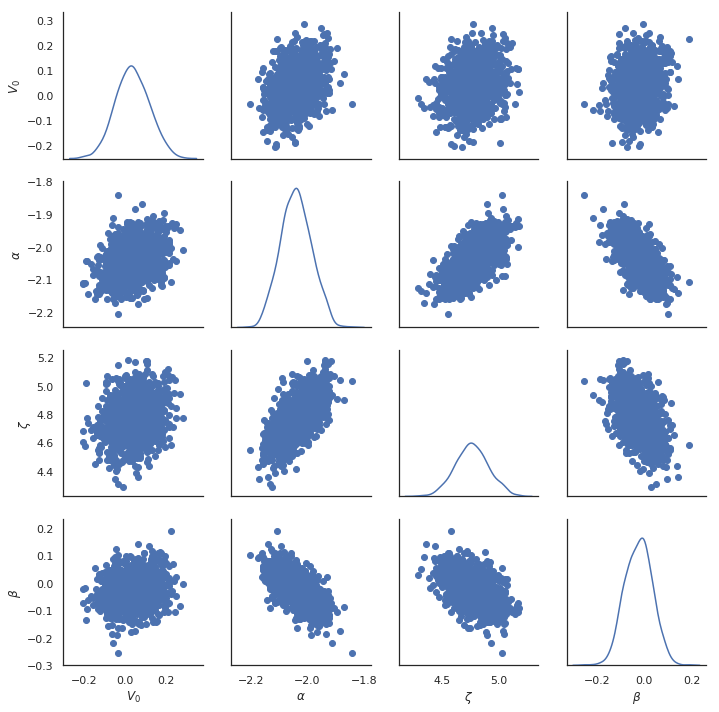

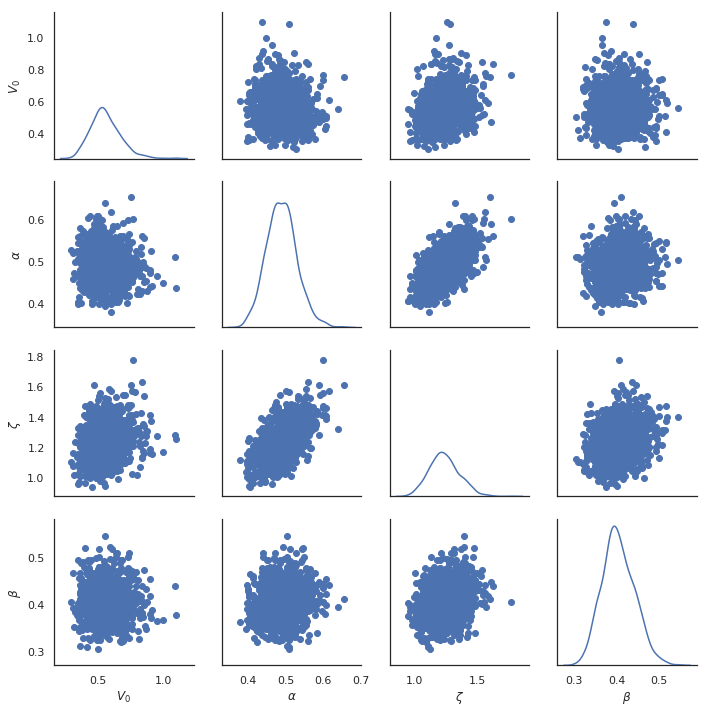

In [14]:
g = sns.PairGrid(mu_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

g = sns.PairGrid(sigma_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

fit HGF agent to simulated data

In [ ]:
stimuli = np.array(sim2.stimulus).reshape(1, -1)
mask = mask.byte()
hgf_infer = Horseshoe(hgf_agent, stimuli, sim2.responses, mask=mask)
hgf_infer.infer_posterior(iter_steps=1000)

labels = [r'$\mu_0^1$', r'$\mu_0^2$', r'$\eta$', r'$\zeta$', r'$\beta$']
hgf_tp_df, hgf_mu_df, hgf_sigma_df = hgf_infer.sample_posterior(labels, n_samples=1000)

In [16]:
labels = [r'$\mu_0^1$', r'$\mu_0^2$', r'$\eta$', r'$\zeta$', r'$\beta$']
trans_pars_hgf = hgf_tp_df.melt(id_vars='subject', var_name='parameter')

vals = [trans_pars2[:, i].numpy() for i in range(len(labels))]
posterior_accuracy(labels, trans_pars_hgf, vals)

$\mu_0^1$ 1.0
$\mu_0^2$ 1.0
$\eta$ 1.0
$\zeta$ 1.0
$\beta$ 0.98


Plot posterior estimates from simulated data for the HGF agent

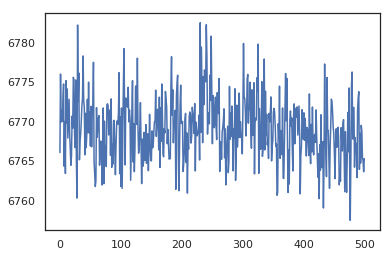

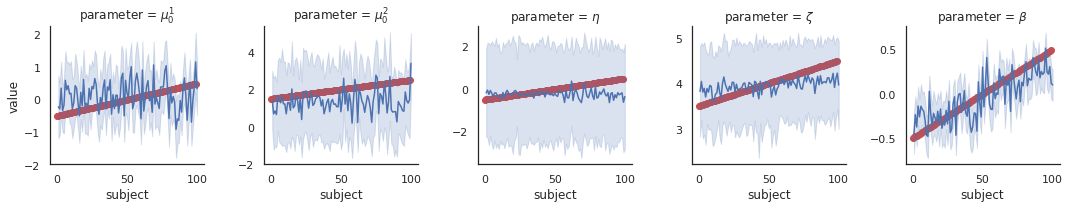

In [18]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(hgf_infer.loss[-500:])

g = sns.FacetGrid(trans_pars_hgf, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

for i in range(len(labels)):
    g.axes[0,i].plot(np.arange(2*nsub), trans_pars2[:,i].numpy(),'ro', zorder = 0);

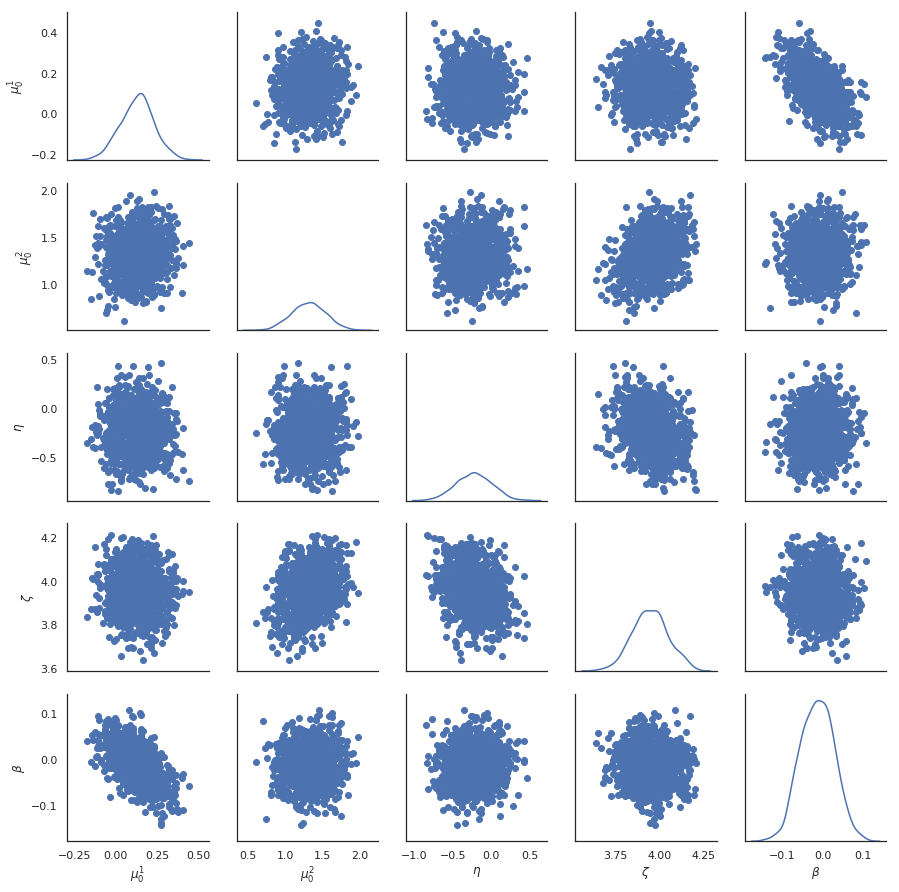

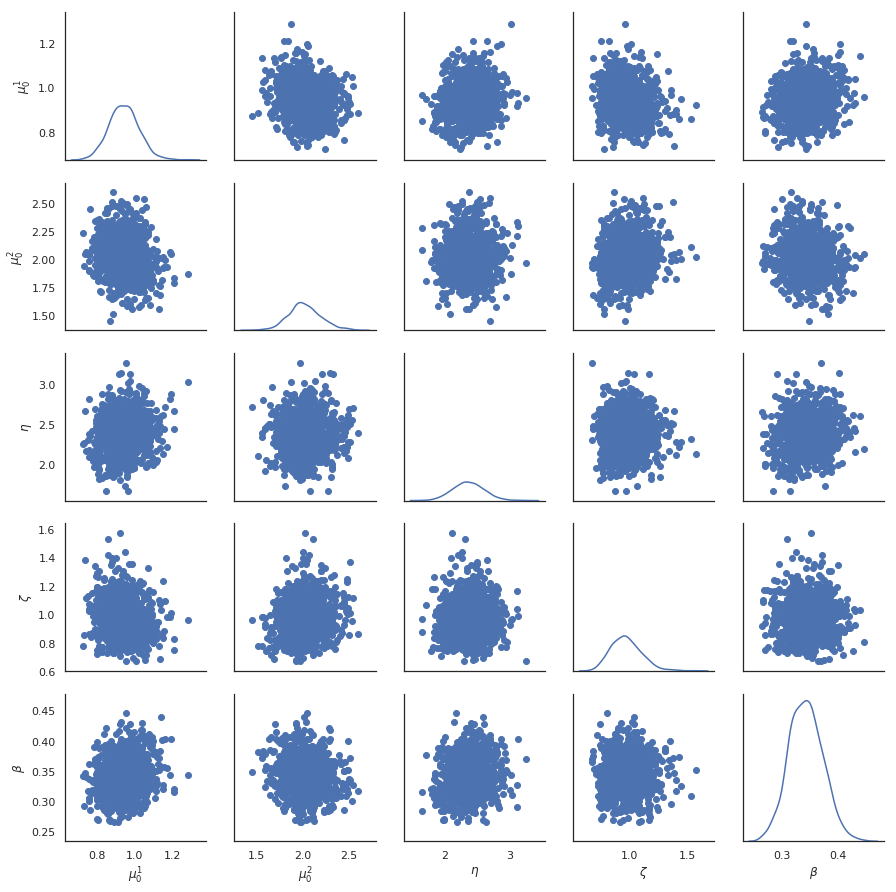

In [23]:
g = sns.PairGrid(hgf_mu_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

g = sns.PairGrid(hgf_sigma_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

In [10]:
stimuli = np.array(sim3.stimulus).reshape(1, -1)
mask = mask.byte()
sgf_infer = Horseshoe(sgf_agent, stimuli, sim3.responses, mask=mask)
sgf_infer.infer_posterior(iter_steps=1000)

labels = [r'$\mu_0$', r'$\rho_1$', r'$h$',  r'$\zeta$', r'$\beta$']
sgf_tp_df, sgf_mu_df, sgf_sigma_df = sgf_infer.sample_posterior(labels, n_samples=1000)

Mean ELBO 6947.57: 100%|██████████| 1000/1000 [32:24<00:00,  1.94s/it]


In [20]:
labels = [r'$\mu_0$', r'$\rho_1$', r'$h$',  r'$\zeta$', r'$\beta$']
trans_pars_sgf = sgf_tp_df.melt(id_vars='subject', var_name='parameter')

vals = [trans_pars3[:, i].numpy() for i in range(len(labels))]
posterior_accuracy(labels, trans_pars_sgf, vals)

$\mu_0$ 0.99
$\rho_1$ 1.0
$h$ 1.0
$\zeta$ 1.0
$\beta$ 0.99


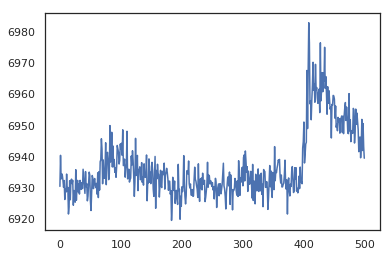

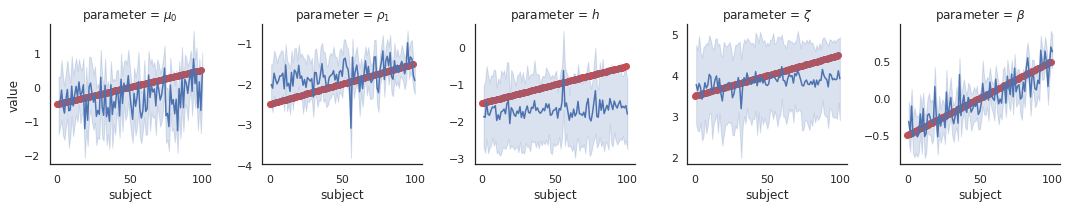

In [22]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(sgf_infer.loss[-500:])

g = sns.FacetGrid(trans_pars_sgf, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

for i in range(len(labels)):
    g.axes[0,i].plot(np.arange(2*nsub), trans_pars3[:,i].numpy(),'ro', zorder = 0);

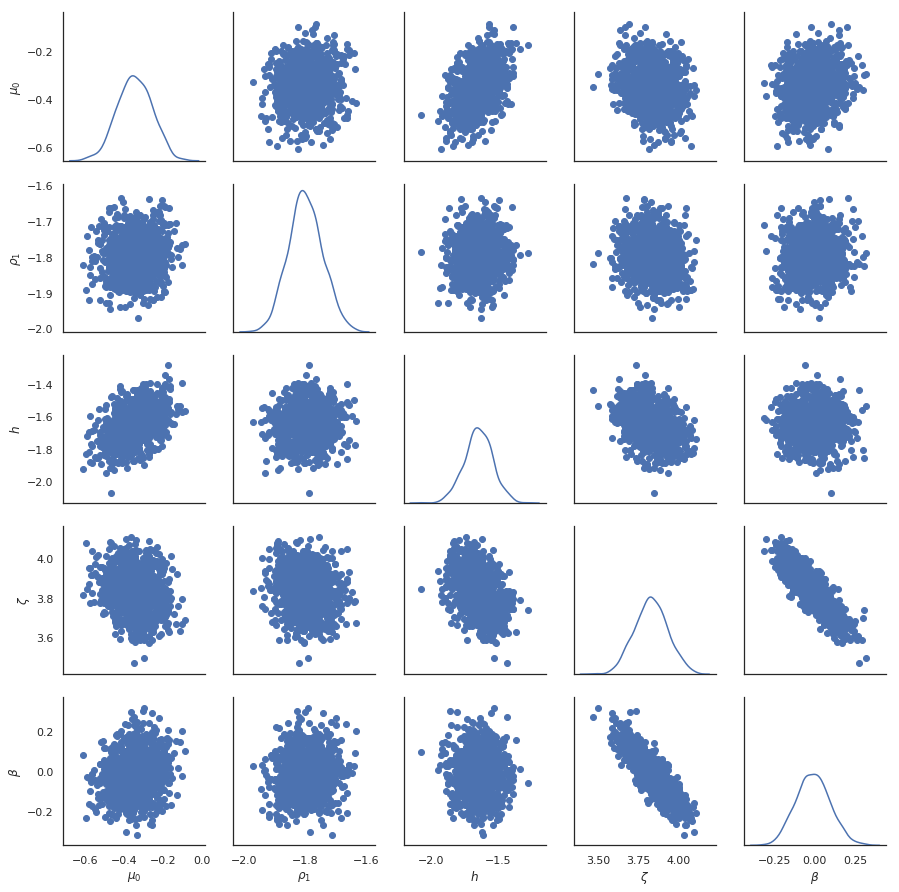

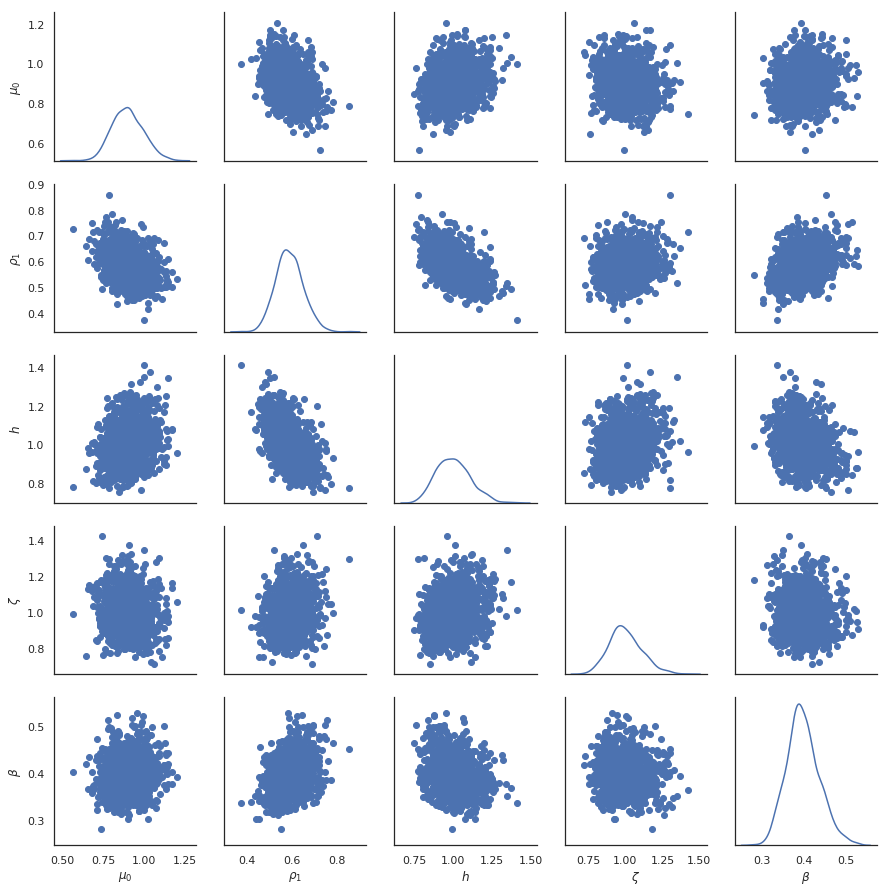

In [24]:
g = sns.PairGrid(sgf_mu_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

g = sns.PairGrid(sgf_sigma_df)
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)

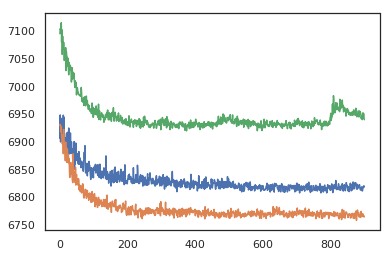

In [25]:
plt.plot(rl_infer.loss[-900:]);
plt.plot(hgf_infer.loss[-900:]);
plt.plot(sgf_infer.loss[-900:]);

In [4]:
stimuli = np.array(sim1.stimulus).reshape(1, -1)
mask = mask.byte()

In [5]:
rl_infer = [Horseshoe(rl_agent, stimuli, sim1.responses, mask=mask),
            Horseshoe(rl_agent, stimuli, sim2.responses, mask=mask),
            Horseshoe(rl_agent, stimuli, sim3.responses, mask=mask)]
evidences = torch.zeros(3, 3, 2*nsub)
for i in range(3):
    rl_infer[i].infer_posterior(iter_steps = 1000)
    evidences[0, i] = rl_infer[i].get_log_evidence_per_subject()
    
hgf_infer = [Horseshoe(hgf_agent, stimuli, sim1.responses, mask=mask),
             Horseshoe(hgf_agent, stimuli, sim2.responses, mask=mask),
             Horseshoe(hgf_agent, stimuli, sim3.responses, mask=mask)]

for i in range(3):
    hgf_infer[i].infer_posterior(iter_steps = 1000)
    evidences[1, i] = hgf_infer[i].get_log_evidence_per_subject()
    
sgf_infer = [Horseshoe(sgf_agent, stimuli, sim1.responses, mask=mask),
             Horseshoe(sgf_agent, stimuli, sim2.responses, mask=mask),
             Horseshoe(sgf_agent, stimuli, sim3.responses, mask=mask)]

for i in range(3):
    sgf_infer[i].infer_posterior(iter_steps = 1000)
    evidences[2, i] = sgf_infer[i].get_log_evidence_per_subject()

Mean ELBO 6934.16: 100%|██████████| 1000/1000 [30:36<00:00,  1.80s/it]


In [17]:
print((evidences[:, 0].argmax(dim=0) == 0).sum().float()/(2*nsub))
print((evidences[:, 1].argmax(dim=0) == 1).sum().float()/(2*nsub))
print((evidences[:, 2].argmax(dim=0) == 2).sum().float()/(2*nsub))
evidences.sum(-1)

tensor(0.6000)
tensor(0.4800)
tensor(0.3600)


tensor([[-6779.8438, -6747.2051, -6908.5723],
        [-6813.3770, -6736.0518, -6900.1826],
        [-6810.2515, -6899.3403, -6897.6689]])

The diagonal elements in the above matrix are the lowest values for the corresponding column, which shows that we can accuretly infer the correct model over population. The question is what would be results per subject.